# Data Analytics - ML25M 

### Imports

In [1]:
import torch
import time
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from torch.utils.tensorboard import SummaryWriter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# from tab_transformer_pytorch import TabTransformer
# from pytorch_tabnet.tab_model import TabNetClassifier
# from pytorch_tabular import TabularModel
# from pytorch_tabular.models import CategoryEmbeddingModelConfig
# from pytorch_tabular.config import (
#     DataConfig,
#     OptimizerConfig,
#     TrainerConfig,
# )

def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

fix_random(42)


## Data Acquisition

movies.csv contains the following fields:

* movieId - a unique identifier for each movie.
* title - the title of the movie.
* genres - a pipe-separated list of genres for the movie.

It will be used to get the movie title and the genres.

In [2]:
movies_df = pd.read_csv('./ml-25m/movies.csv')
genres = movies_df['genres'].str.get_dummies(sep='|')
movies_df = pd.concat([movies_df, genres], axis=1)
movies_df.drop('genres', axis=1, inplace=True)
movies_df.head(3)


,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


genome-scores.csv contains the following fields:

* movieId - a unique identifier for each movie.
* tagId - a unique identifier for each tag.
* relevance - a score from 0.0 to 1.0 representing the relevance of the tag to the movie.

Combined with the tags.csv file, this will be used to assign tags and their relevance to each movie.

In [3]:
scores_df = pd.read_csv('./ml-25m/genome-scores.csv')
tags_df = pd.read_csv('./ml-25m/genome-tags.csv')
ratings_df = pd.read_csv('./ml-25m/ratings.csv')

df = movies_df.merge(scores_df, on='movieId')
df = df.merge(tags_df, on='tagId')
df = df.pivot_table(index=['movieId', 'title'], columns='tag', values='relevance', fill_value=0).reset_index().rename_axis(None, axis=1)

# average rating for each movie
ratings_df = ratings_df.groupby(['movieId'])['rating'].mean().reset_index()

#  round ratings to the nearest 0.5
# ratings_df['rating_rounded'] = ratings_df['rating'].apply(lambda x: round(x * 2) / 2)

# # mode rating for each movie
# ratings_df = ratings_df.groupby(['movieId'])['rating'].agg(lambda x: x.value_counts().index[0]).reset_index()

df = ratings_df.merge(df, on='movieId')

# movieId and title are not needed for the model
df.drop(['movieId', 'title'], axis=1, inplace=True)

In [ ]:
# save the dataframe to a csv file
df.to_csv('./dataset.csv', index=False)

## Data visualization

In [4]:
print(f'Number of samples: {df.shape[0]}')
df.describe()

Number of samples: 13816


,rating,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
count,13816.000000,13816.000000,13816.000000,13816.000000,13816.000000,13816.000000,13816.000000,13816.000000,13816.000000,13816.000000,...,13816.000000,13816.000000,13816.000000,13816.000000,13816.000000,13816.000000,13816.000000,13816.000000,13816.000000,13816.000000
mean,3.272180,0.046596,0.044771,0.078292,0.085599,0.129250,0.088348,0.074092,0.180610,0.096887,...,0.117631,0.043644,0.048769,0.062500,0.245069,0.097053,0.041831,0.042961,0.125901,0.031766
std,0.484078,0.071478,0.062601,0.111595,0.086021,0.146648,0.105167,0.100385,0.140021,0.134208,...,0.136072,0.083196,0.146318,0.083094,0.122572,0.089406,0.074281,0.135702,0.104373,0.084668
min,0.899038,0.007000,0.007250,0.006000,0.010000,0.017250,0.004250,0.004500,0.015250,0.002250,...,0.009250,0.004000,0.002500,0.003500,0.039750,0.006750,0.005250,0.001500,0.034750,0.007750
25%,2.986574,0.025750,0.026750,0.028750,0.037250,0.053250,0.029500,0.024500,0.079750,0.024750,...,0.052000,0.017250,0.011000,0.022500,0.160250,0.042000,0.021500,0.008500,0.081500,0.016500
50%,3.340420,0.033750,0.034750,0.042000,0.056000,0.078250,0.052750,0.041500,0.137750,0.047750,...,0.072250,0.022500,0.015250,0.039750,0.216500,0.069000,0.028000,0.012250,0.097500,0.019000
75%,3.629630,0.045312,0.047250,0.079500,0.102250,0.136000,0.101500,0.078750,0.235750,0.107250,...,0.118250,0.034000,0.024000,0.074000,0.296250,0.119000,0.038312,0.020000,0.126000,0.023500
max,4.483096,0.999750,1.000000,0.997750,0.922000,0.988000,0.920000,0.913500,0.925500,0.987000,...,0.999250,0.981000,0.999000,0.992750,0.972500,0.974750,1.000000,0.995250,0.992250,0.994250


In [5]:
# mean, median, and standard deviation of ratings
print("Mode: ", df['rating'].mode())
print('Median: {:.2f}'.format(df['rating'].median()))
print('Std: {:.2f}'.format(df['rating'].std()))

Mode:  0    3.5
Name: rating, dtype: float64
Median: 3.34
Std: 0.48


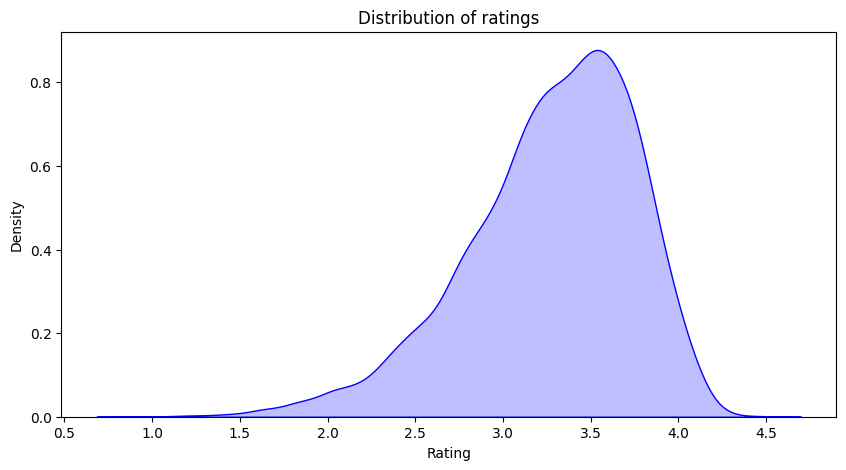

In [6]:
# density plot of ratings
plt.figure(figsize=(10, 5))
sns.kdeplot(df['rating'], shade=True, color='blue')
plt.title('Distribution of ratings')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.show()

In [7]:
N_LABELS = df.rating.nunique()
print(f'Number of labels: {N_LABELS}')

# looking for missing values and duplicates
print("Nan: ", df.isna().sum().sum())
print("Duplicates: ", df.duplicated().sum())

Number of labels: 12002
Nan:  0
Duplicates:  0


## 2D Representation of the dataset

In [1]:
df_random = df.sample(6000)

X = df_random.drop('rating', axis=1)
Y = df_random['rating']

NameError: name 'df' is not defined

In [25]:
# tsne 
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
X = tsne.fit_transform(X)

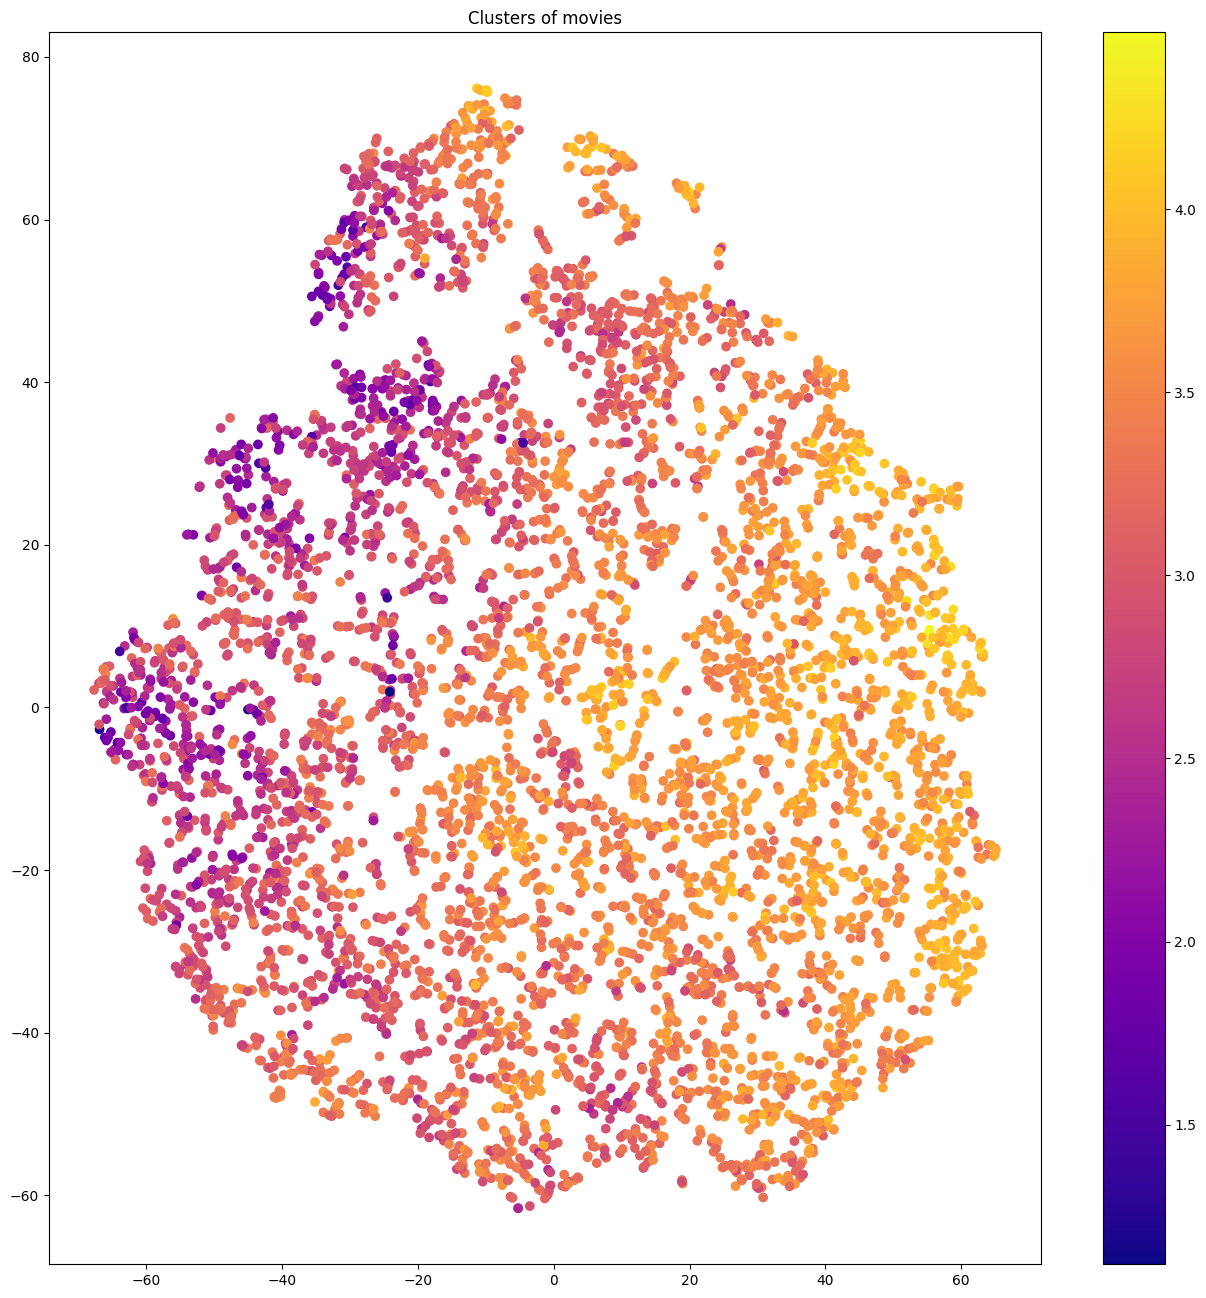

In [31]:
# plot
plt.figure(figsize=(16, 16))
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='plasma')
plt.title('Clusters of movies')
plt.colorbar()
plt.show()

## Modeling

### Deep Learning for Tabular Data

[PyTorch Tabular](https://github.com/manujosephv/pytorch_tabular#installation)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of validation samples: {X_val.shape[0]}')


NameError: name 'X_train' is not defined

### TabTransformer

In [ ]:
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]="1"

train, test = train_test_split(df, random_state=42)
train, val = train_test_split(train, random_state=42)

In [ ]:
# categorical headers
cat_headers = ['rating']

# numerical headers
num_headers = list(set(df.columns) - set(cat_headers))

data_config = DataConfig(
    target=[
        "rating"
    ],  # target should always be a list. Multi-targets are only supported for regression. Multi-Task Classification is not implemented
    continuous_cols=num_headers,
    categorical_cols=cat_headers,
)
trainer_config = TrainerConfig(
    auto_lr_find=True,  # Runs the LRFinder to automatically derive a learning rate
    batch_size=1024,
    max_epochs=100,
)
optimizer_config = OptimizerConfig()

model_config = CategoryEmbeddingModelConfig(
    task="classification",
    layers="1024-512-512",  # Number of nodes in each layer
    activation="LeakyReLU",  # Activation between each layers
    learning_rate=1e-3,
)

In [ ]:
# Initialize the model
tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)
tabular_model.fit(train=train, validation=val)

2023-03-02 14:26:59,618 - {pytorch_tabular.tabular_model:102} - INFO - Experiment Tracking is turned off
Global seed set to 42
2023-03-02 14:26:59,686 - {pytorch_tabular.tabular_model:465} - INFO - Preparing the DataLoaders
2023-03-02 14:26:59,700 - {pytorch_tabular.tabular_datamodule:286} - INFO - Setting up the datamodule for classification task
2023-03-02 14:27:00,708 - {pytorch_tabular.tabular_model:508} - INFO - Preparing the Model: CategoryEmbeddingModel
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabular/models/base_model.py:132: UserWarning: Plotly is not installed. Please install plotly to log logits. You can install plotly using pip install plotly or install PyTorch Tabular using pip install pytorch-tabular[all]
  warnings.warn(
2023-03-02 14:27:00,857 - {pytorch_tabular.tabular_model:264} - INFO - Preparing the Trainer
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU

NotImplementedError: The operator 'aten::_unique2' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [ ]:
# evaluate the model
result = tabular_model.evaluate([X_val,Y_val])
pred_df = tabular_model.predict(X_test)
tabular_model.save_model("tabTransformer/model")
loaded_model = TabularModel.load_from_checkpoint("tabTransformer/model")

## Evaluation